In [1]:
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
from astropy.io import fits
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
from astropy.visualization import simple_norm
import regions
from regions import Regions
from astropy.table import Table
from astropy.nddata import Cutout2D
from scipy.ndimage import gaussian_filter
import reproject
from reproject import reproject_interp

In [2]:
cd ..

/blue/adamginsburg/savannahgramze/cloudc/lactea-filament/lactea-filament


In [3]:
from jwst_plots import JWSTCatalog
from jwst_plots import make_cat_use
from extinction import star_density_color, make_wcs

Set DATE-AVG to '2023-04-20T10:07:44.724' from MJD-AVG.
Set DATE-END to '2023-04-25T05:06:53.406' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to    -3.177752 from OBSGEO-[XYZ].
Set OBSGEO-H to 1298809712.873 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


In [4]:
basepath = '/orange/adamginsburg/jwst/cloudc/'
#'/home/savannahgramze/research/Research/JWST/cloudc/'

# Load Catalog

In [5]:
fn_405 = f'{basepath}/images/F405_reproj_merged-fortricolor.fits'
ww = WCS(fits.open(fn_405)[0].header)

In [6]:
data_405 = fits.getdata(fn_405)

In [7]:
image_area = image_area = np.sum((data_405 != 0) & (np.isnan(data_405) == False)) * ww.proj_plane_pixel_area().to(u.arcsec**2)
#data_405.size * ww.proj_plane_pixel_area().to(u.arcsec**2)
print(image_area)

70265.9036456803 arcsec2


In [8]:
#cat_fn = f'{basepath}/catalogs/basic_merged_indivexp_photometry_tables_merged.fits'
#basetable = Table.read(cat_fn)

In [8]:
#base_jwstcatalog = JWSTCatalog(basetable)
#mask_qf = base_jwstcatalog.get_qf_mask(0.4)
cat_use = make_cat_use()#JWSTCatalog(basetable[mask_qf])

In [9]:
reg_filament = Regions.read(f'./regions_/filament_long.region')
reg_filhole = Regions.read(f'./regions_/filhole.region')
reg_cloudd = Regions.read(f'./regions_/cloudd.region')
reg_cloudc1 = Regions.read(f'./regions_/cloudc1.region')
reg_cloudc2 = Regions.read(f'./regions_/cloudc2.region')
#reg_filament_long = Regions.read(f'{basepath}/regions_/filament_long.region')

In [10]:
area_filament = reg_filament[0].to_pixel(ww).area*u.pixel**2 * ww.proj_plane_pixel_area().to(u.arcsec**2)/(u.pixel**2)
area_cloudd = reg_cloudd[0].to_pixel(ww).area*u.pixel**2 * ww.proj_plane_pixel_area().to(u.arcsec**2)/(u.pixel**2)
area_cloudc1 = reg_cloudc1[0].to_pixel(ww).area*u.pixel**2 * ww.proj_plane_pixel_area().to(u.arcsec**2)/(u.pixel**2)
area_cloudc2 = reg_cloudc2[0].to_pixel(ww).area*u.pixel**2 * ww.proj_plane_pixel_area().to(u.arcsec**2)/(u.pixel**2)

In [11]:
cat_filament = JWSTCatalog(cat_use.table_region_mask(reg_filament, wcs=ww))
cat_cloudd =   JWSTCatalog(cat_use.table_region_mask(reg_cloudd, wcs=ww))
cat_cloudc1 =  JWSTCatalog(cat_use.table_region_mask(reg_cloudc1, wcs=ww))
cat_cloudc2 =  JWSTCatalog(cat_use.table_region_mask(reg_cloudc2, wcs=ww))

In [12]:
mask_outside = ~cat_use.get_region_mask(reg_filament, wcs=ww) & ~cat_use.get_region_mask(reg_cloudd, wcs=ww) & ~cat_use.get_region_mask(reg_cloudc1, wcs=ww) & ~cat_use.get_region_mask(reg_cloudc2, wcs=ww)
cat_outside = JWSTCatalog(cat_use.catalog[mask_outside])

In [13]:
area_outside = image_area - area_filament - area_cloudd - area_cloudc1 - area_cloudc2

In [14]:
mask_filament = cat_use.get_region_mask(reg_filament, wcs=ww) & ~cat_use.get_region_mask(reg_filhole, wcs=ww)
cat_only_filament = JWSTCatalog(cat_use.catalog[mask_filament])

# Bin stars

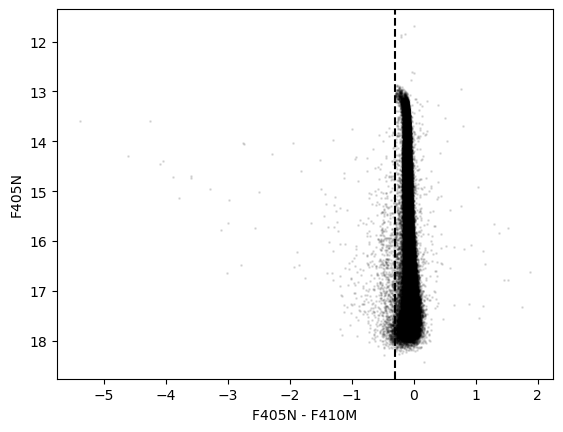

In [ ]:
ax = plt.subplot(111)
cat_use.plot_CMD('F405N', 'F410M', 'F405N', color='black', alpha=0.1, label='All', s=1, ax=ax)
ax.axvline(-0.3, color='black', linestyle='--')

In [ ]:
b = np.linspace(14, 21, 50)
h_filament, b_filament = np.histogram(cat_filament.catalog['mag_ab_f410m'], bins=b)
h_cloudd, b_cloudd = np.histogram(cat_cloudd.catalog['mag_ab_f410m'], bins=b)
h_cloudc1, b_cloudc1 = np.histogram(cat_cloudc1.catalog['mag_ab_f410m'], bins=b)
h_cloudc2, b_cloudc2 = np.histogram(cat_cloudc2.catalog['mag_ab_f410m'], bins=b)
h_outside, b_outside = np.histogram(cat_outside.catalog['mag_ab_f410m'], bins=b)

In [ ]:
h_filament = h_filament/area_filament
h_cloudd = h_cloudd/area_cloudd
h_cloudc1 = h_cloudc1/area_cloudc1
h_cloudc2 = h_cloudc2/area_cloudc2
h_outside = h_outside/area_outside

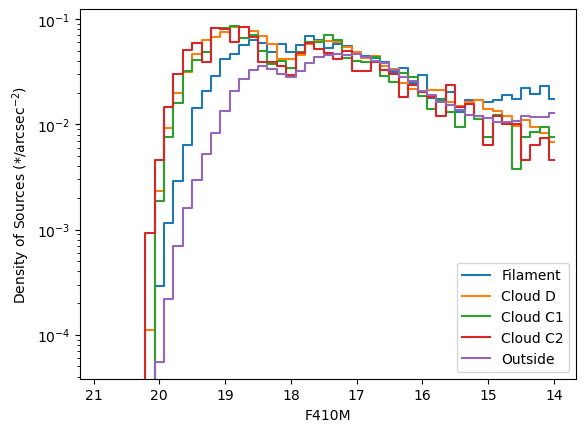

In [ ]:
plt.step(b_filament[:-1], h_filament, label='Filament', where='mid')
plt.step(b_cloudd[:-1], h_cloudd, label='Cloud D', where='mid')
plt.step(b_cloudc1[:-1], h_cloudc1, label='Cloud C1', where='mid')
plt.step(b_cloudc2[:-1], h_cloudc2, label='Cloud C2', where='mid')
plt.step(b_outside[:-1], h_outside, label='Outside', where='mid')

plt.yscale('log')
plt.legend()
plt.xlabel('F410M')
plt.ylabel('Density of Sources (*/arcsec$^{-2}$)')
plt.gca().invert_xaxis()

In [ ]:
b = np.linspace(14, 21, 50)
h_filament, b_filament = np.histogram(cat_filament.catalog['mag_ab_f212n'], bins=b)
h_cloudd, b_cloudd = np.histogram(cat_cloudd.catalog['mag_ab_f212n'], bins=b)
h_cloudc1, b_cloudc1 = np.histogram(cat_cloudc1.catalog['mag_ab_f212n'], bins=b)
h_cloudc2, b_cloudc2 = np.histogram(cat_cloudc2.catalog['mag_ab_f212n'], bins=b)
h_outside, b_outside = np.histogram(cat_outside.catalog['mag_ab_f212n'], bins=b)

In [ ]:
h_filament = h_filament/area_filament
h_cloudd = h_cloudd/area_cloudd
h_cloudc1 = h_cloudc1/area_cloudc1
h_cloudc2 = h_cloudc2/area_cloudc2
h_outside = h_outside/area_outside

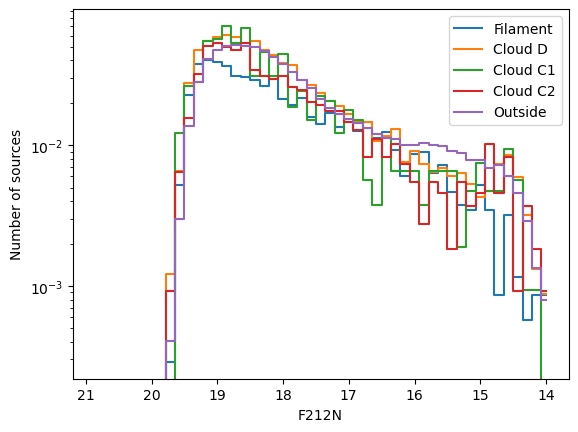

In [ ]:
plt.step(b_filament[:-1], h_filament, label='Filament', where='mid')
plt.step(b_cloudd[:-1], h_cloudd, label='Cloud D', where='mid')
plt.step(b_cloudc1[:-1], h_cloudc1, label='Cloud C1', where='mid')
plt.step(b_cloudc2[:-1], h_cloudc2, label='Cloud C2', where='mid')
plt.step(b_outside[:-1], h_outside, label='Outside', where='mid')

plt.yscale('log')
plt.legend()
plt.xlabel('F212N')
plt.ylabel('Number of sources')
plt.gca().invert_xaxis()

In [ ]:
b = np.linspace(14, 19, 50)
h_filament, b_filament = np.histogram(cat_filament.catalog['mag_ab_f405n'], bins=b)
h_cloudd, b_cloudd = np.histogram(cat_cloudd.catalog['mag_ab_f405n'], bins=b)
h_cloudc1, b_cloudc1 = np.histogram(cat_cloudc1.catalog['mag_ab_f405n'], bins=b)
h_cloudc2, b_cloudc2 = np.histogram(cat_cloudc2.catalog['mag_ab_f405n'], bins=b)
h_outside, b_outside = np.histogram(cat_outside.catalog['mag_ab_f405n'], bins=b)


In [ ]:
h_filament = h_filament/area_filament
h_cloudd = h_cloudd/area_cloudd
h_cloudc1 = h_cloudc1/area_cloudc1
h_cloudc2 = h_cloudc2/area_cloudc2
h_outside = h_outside/area_outside

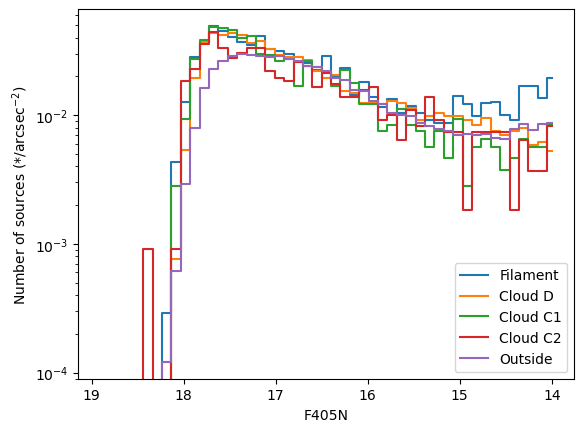

In [ ]:
plt.step(b_filament[:-1], h_filament, label='Filament', where='mid')
plt.step(b_cloudd[:-1], h_cloudd, label='Cloud D', where='mid')
plt.step(b_cloudc1[:-1], h_cloudc1, label='Cloud C1', where='mid')
plt.step(b_cloudc2[:-1], h_cloudc2, label='Cloud C2', where='mid')
plt.step(b_outside[:-1], h_outside, label='Outside', where='mid')

plt.yscale('log')
plt.legend()
plt.xlabel('F405N')
plt.ylabel('Number of sources (*/arcsec$^{-2}$)')
plt.gca().invert_xaxis()

# Spatial Stellar Density

In [26]:
fn = f'{basepath}/images/jw02221-o002_t001_nircam_clear-f405n-merged_i2d.fits'
#/images/F405_reproj_merged-fortricolor.fits'
#'/orange/adamginsburg/jwst/cloudc/images/jw02221-o002_t001_nircam_clear-f405n-merged_i2d.fits'
#im = ImageModel(fn)
hdu = fits.open(fn)[1]
ww = WCS(hdu.header)

position = (hdu.header['CRPIX1'], hdu.header['CRPIX2'])
center = ww.pixel_to_world(position[0], position[1])
size = (2.55*u.arcmin, 8.4*u.arcmin)
cutout = Cutout2D(hdu.data, position=position, size=size, wcs=ww)

reg = regions.RectangleSkyRegion(center=center, 
                                 width=size[0], height=size[1], angle=8*u.deg)
#crds_in = crds_ref[reg.contains(crds_ref, wcs=cutout.wcs)]
crds_in = cat_use.table_region_mask([reg], wcs=ww)['skycoord_ref']

#plt.figure(figsize=(14,8))
#ax = plt.subplot(111, projection=ww)
##ax = plt.subplot(111, projection=cutout.wcs)
##ax.imshow(cutout.data, vmin=0, vmax=50)
#ax.imshow(hdu['SCI'].data, vmin=0, vmax=50)
##ax.scatter(crds_ref.ra, crds_ref.dec, edgecolor='r', facecolor='none', transform=ax.get_transform('world'), marker='.')
#ax.scatter(crds_in.ra, crds_in.dec, edgecolor='r', facecolor='none', transform=ax.get_transform('world'), marker='.')
#
#plt.tight_layout()
#plt.show()

Set DATE-AVG to '2023-04-20T10:07:44.724' from MJD-AVG.
Set DATE-END to '2023-04-25T05:06:53.406' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to    -3.177752 from OBSGEO-[XYZ].
Set OBSGEO-H to 1298809712.873 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


## Making the Grid

In [27]:
size = (2.55*u.arcmin, 8.4*u.arcmin)
bins_ra = np.arange(0, size[1].to(u.arcsec).value, 1)
bins_dec = np.arange(0, size[0].to(u.arcsec).value, 1)

In [28]:
bins_pix_ra = bins_ra/ww.proj_plane_pixel_scales()[1].to(u.arcsec).value
bins_pix_dec= bins_dec/ww.proj_plane_pixel_scales()[1].to(u.arcsec).value

## Putting Catalog Into Grid

In [29]:
crds_use_pix = np.array(ww.world_to_pixel(crds_in))#.T

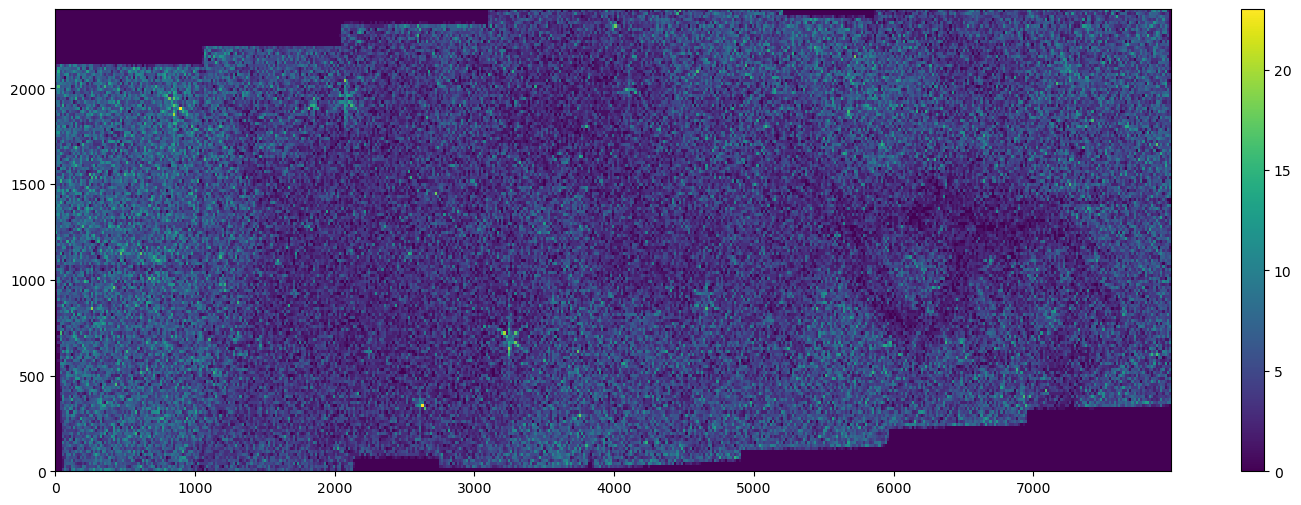

In [30]:
plt.figure(figsize=(18, 6))
plt.hist2d(crds_use_pix[0], crds_use_pix[1], bins=[bins_pix_ra, bins_pix_dec])
plt.colorbar()
print()

## Color

In [31]:
color = cat_use.catalog['mag_ab_f182m'] - cat_use.catalog['mag_ab_f410m']

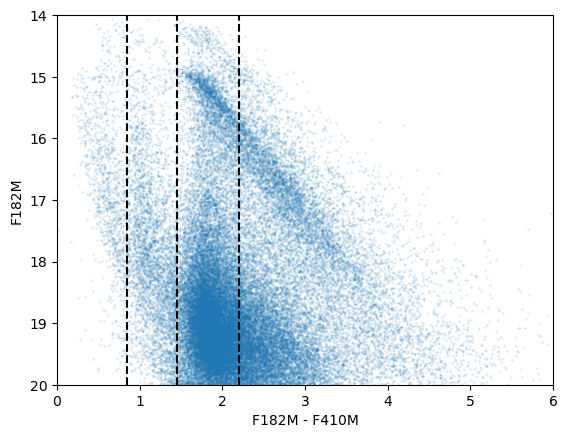

In [45]:
ax = plt.subplot(111)
cat_use.plot_CMD('F182M', 'F410M', 'F182M', alpha=0.1, label='All', s=1, ax=ax)
ax.set_xlim(0, 6)
ax.set_ylim(20, 14)
ax.axvline(0.85, color='k', linestyle='--')
ax.axvline(1.45, color='k', linestyle='--')
ax.axvline(2.2, color='k', linestyle='--')

In [35]:
bins_color = np.arange(0, 6, 1)

In [36]:
color_couples = np.array([(b, b+1) for b in bins_color])
color_couples

array([[0, 1],
       [1, 2],
       [2, 3],
       [3, 4],
       [4, 5],
       [5, 6]])

In [37]:
color_couples = [(0, 0.85), (0.85, 1.45), (1.45, 2), (2, 3), (3, 4), (4, 5), (5, 6)]

## Color Slices

In [38]:
def star_density_color(tbl, ww, dx=1, blur=False):
    pos_smudge = SkyCoord('17:46:23.6171497910', '-28:36:43.0690114397', unit=(u.hourangle, u.deg), frame='icrs')
    size = (2.55*u.arcmin, 8.4*u.arcmin) # approx size of field
    bins_ra = np.arange(0, size[1].to(u.arcsec).value, dx)
    bins_dec = np.arange(0, size[0].to(u.arcsec).value, dx)

    bins_pix_ra = bins_ra/ww.proj_plane_pixel_scales()[1].to(u.arcsec).value
    bins_pix_dec= bins_dec/ww.proj_plane_pixel_scales()[1].to(u.arcsec).value

    crds_pix = np.array(ww.world_to_pixel(tbl['skycoord_ref']))

    plt.figure(figsize=(18, 6))
    ax = plt.subplot(111, projection=ww)
    ax.set_xlabel('RA')
    ax.set_ylabel('Dec')
    h, xedges, yedges = np.histogram2d(crds_pix[0], crds_pix[1], bins=[bins_pix_ra, bins_pix_dec])
    if not blur:
        h1, xedges1, yedges1, y = ax.hist2d(crds_pix[0], crds_pix[1], bins=[bins_pix_ra, bins_pix_dec])
        plt.colorbar(h1)
        return h
    elif blur:
        blurred = gaussian_filter(h, 1)
        im = ax.imshow(blurred.swapaxes(0,1))
        plt.colorbar(im)
        return blurred

def make_wcs(h_noshort, hdu):
    wcs_dict = {
        'SIMPLE' : 'T',
        'BITPIX' : -64,
        'NAXIS' : 2,
        'NAXIS1' : h_noshort.shape[0],
        'NAXIS2' : h_noshort.shape[1],
        'WCSAXES' : 2,
        'CRPIX1' : h_noshort.shape[0]/2,
        'CRPIX2' : h_noshort.shape[1]/2,
        'CDELT1' : -(2*u.arcsec).to(u.deg).value,
        'CDELT2' : (2*u.arcsec).to(u.deg).value,
        'CROTA2' : 354.6-270,
        'CUNIT1' : 'deg',
        'CUNIT2' : 'deg',
        'CTYPE1' : 'RA---TAN',
        'CTYPE2' : 'DEC--TAN',
        'CRVAL1' : hdu['SCI'].header['CRVAL1'],
        'CRVAL2' : hdu['SCI'].header['CRVAL2'],
        #'LONPOL' : 180.0,
        #'LATPOL' : 0.0,
        #'MJDREF' : 0.0,
        'BUNIT' : '# Stars/px'
    }
    input_wcs = astropy.wcs.WCS(wcs_dict)
    return input_wcs

def make_cube(tbl, ww, hdu, dx=1, blur=False):
    tbl_noshort = tbl[~(np.isnan(tbl['mag_ab_f410m'])) & ~(np.isnan(tbl['mag_ab_f410m'])) & (np.isnan(tbl['mag_ab_f182m']))]
    h_noshort = star_density_color(tbl_noshort, ww, dx=dx, blur=blur)
    
    tbl_use = tbl[~(np.isnan(tbl['mag_ab_f410m'])) & ~(np.isnan(tbl['mag_ab_f410m'])) & ~(np.isnan(tbl['mag_ab_f182m']))]
    cube = np.array([star_density_color(tbl_use[(color > lowmag) & (color < highmag)], ww, dx=dx, blur=blur) for lowmag, highmag in color_couples])

    cube_full = np.concatenate([cube, h_noshort.reshape((1,h_noshort.shape[0],h_noshort.shape[1]))])
    input_wcs = make_wcs(h_noshort, hdu)
    hdu_cube = fits.PrimaryHDU(data=cube_full.swapaxes(1,2), header=input_wcs.to_header())

    return hdu_cube

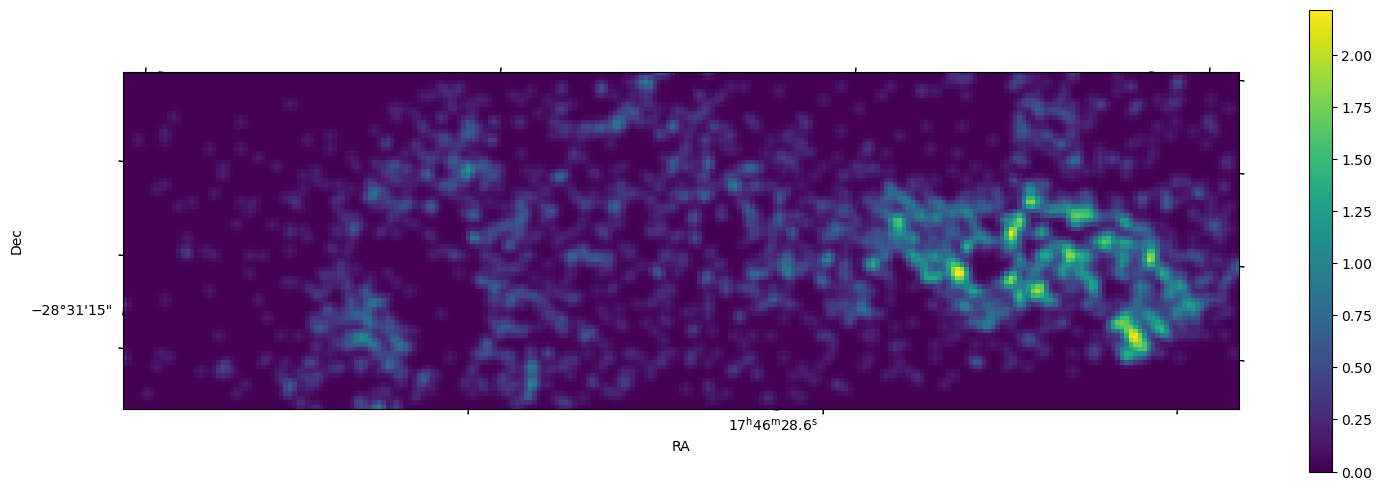

In [40]:
tbl_color1 = cat_use.catalog[(color>4) & (color<5)]# & (cat_use.catalog['mag_ab_f410m']<20)]
h = star_density_color(tbl_color1, ww, dx=2, blur=True)

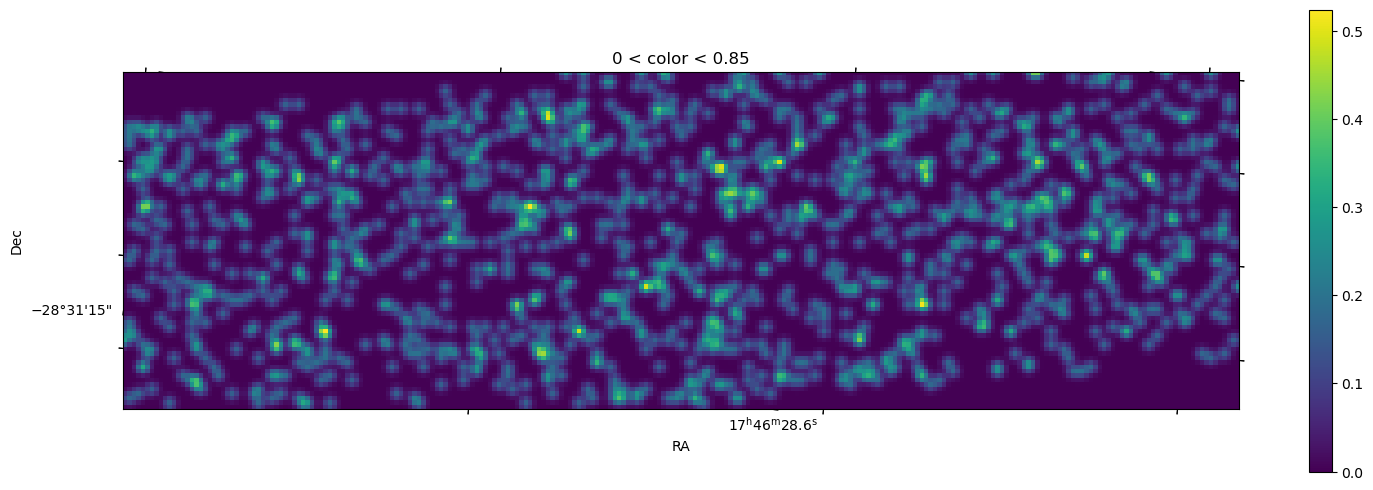

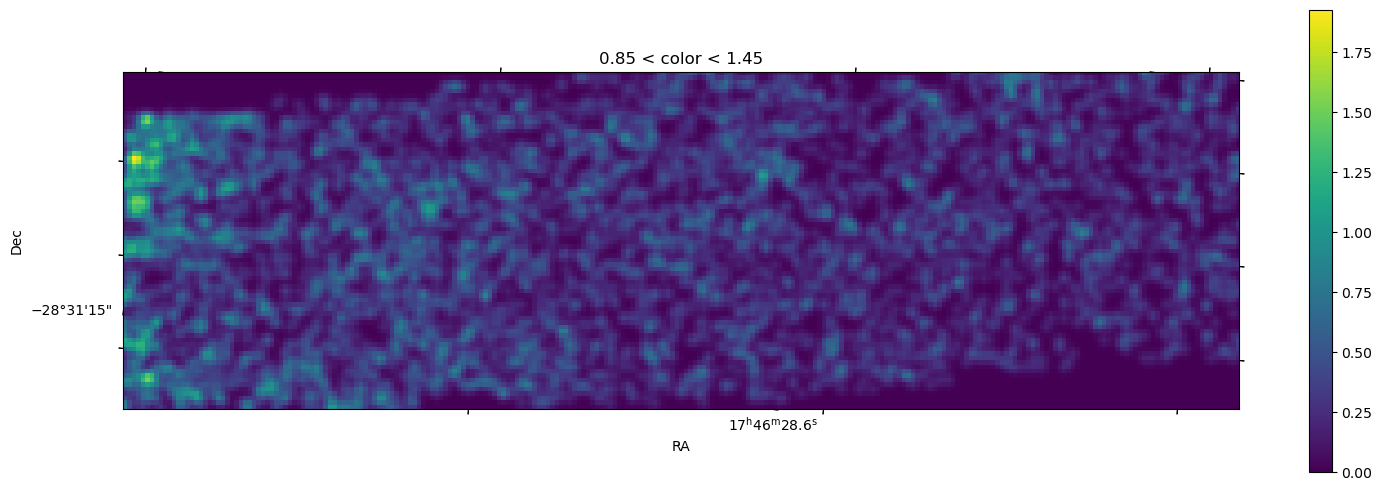

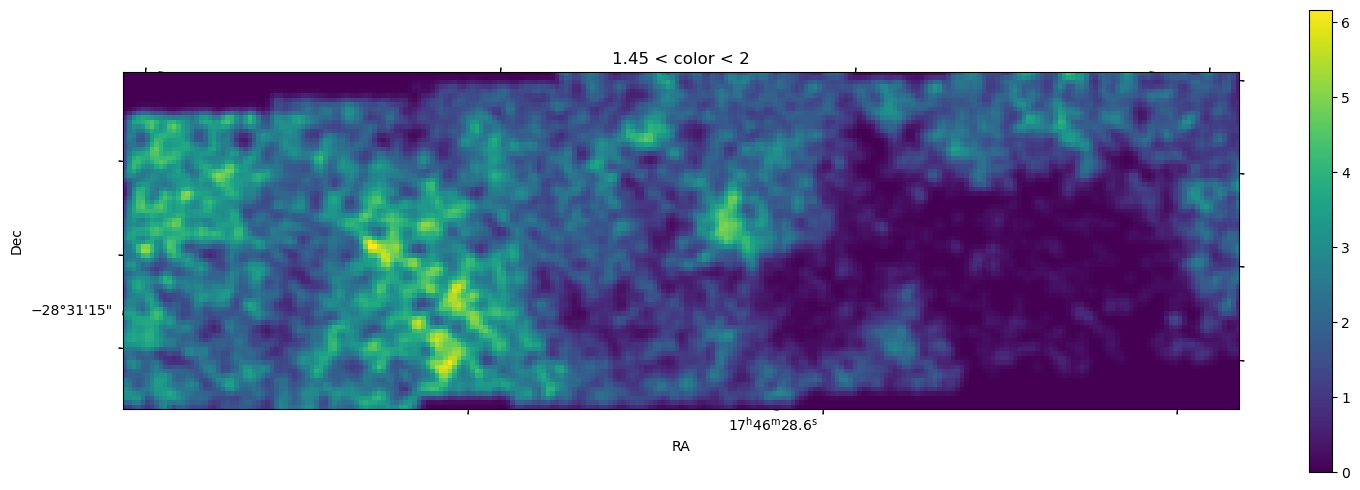

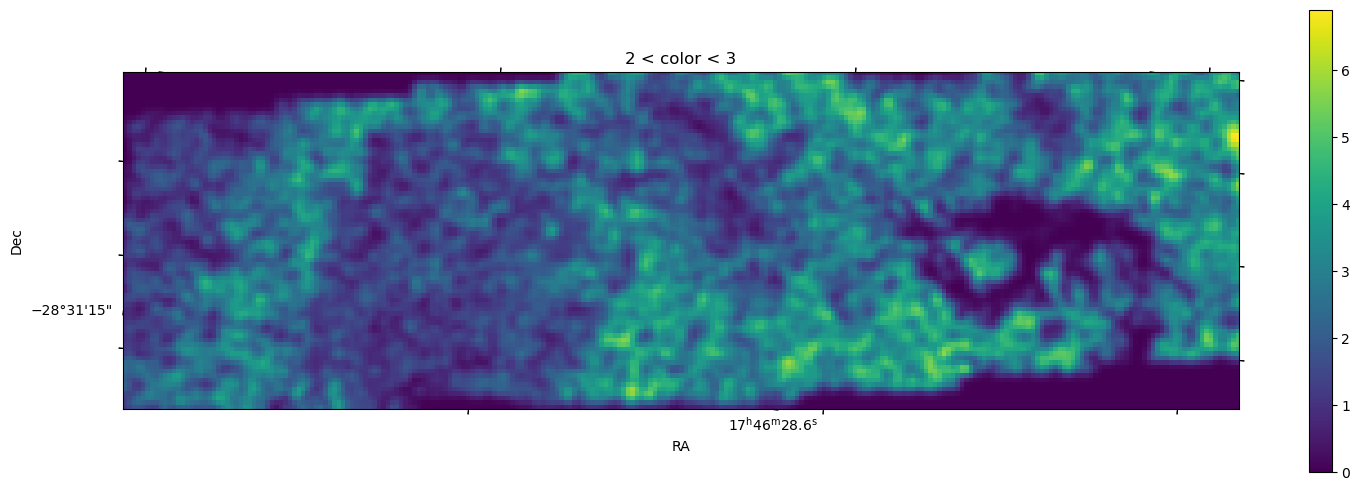

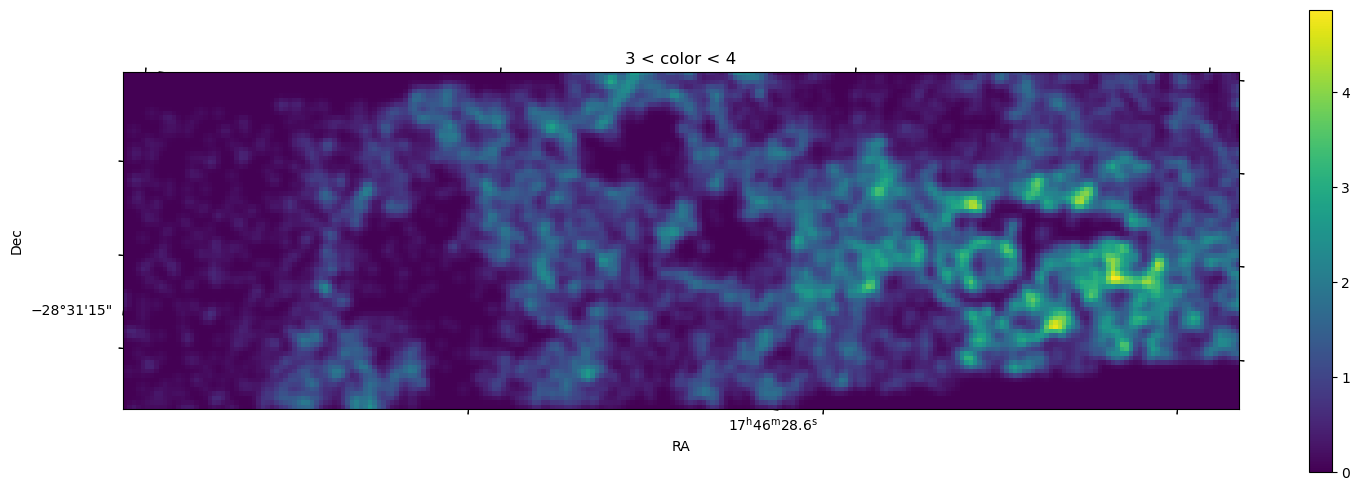

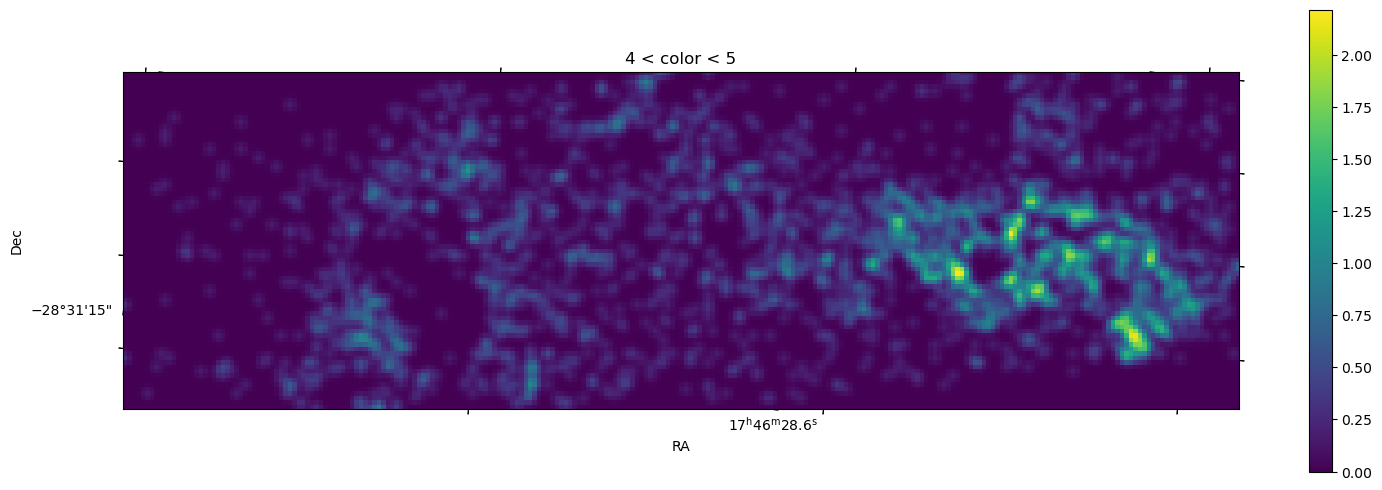

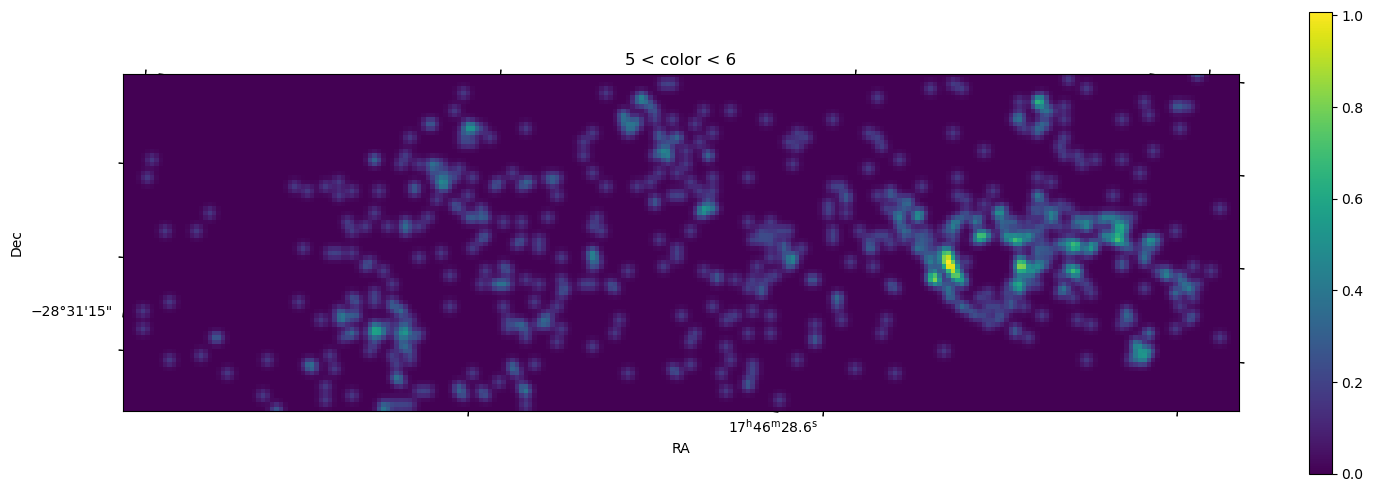

In [41]:
for c in color_couples:
    tbl_color = cat_use.catalog[(color>c[0]) & (color<c[1])]# & (cat_use.catalog['mag_ab_f410m']<20)]
    h = star_density_color(tbl_color, ww, dx=2, blur=True)
    plt.title(f'{c[0]} < color < {c[1]}')
    plt.show()

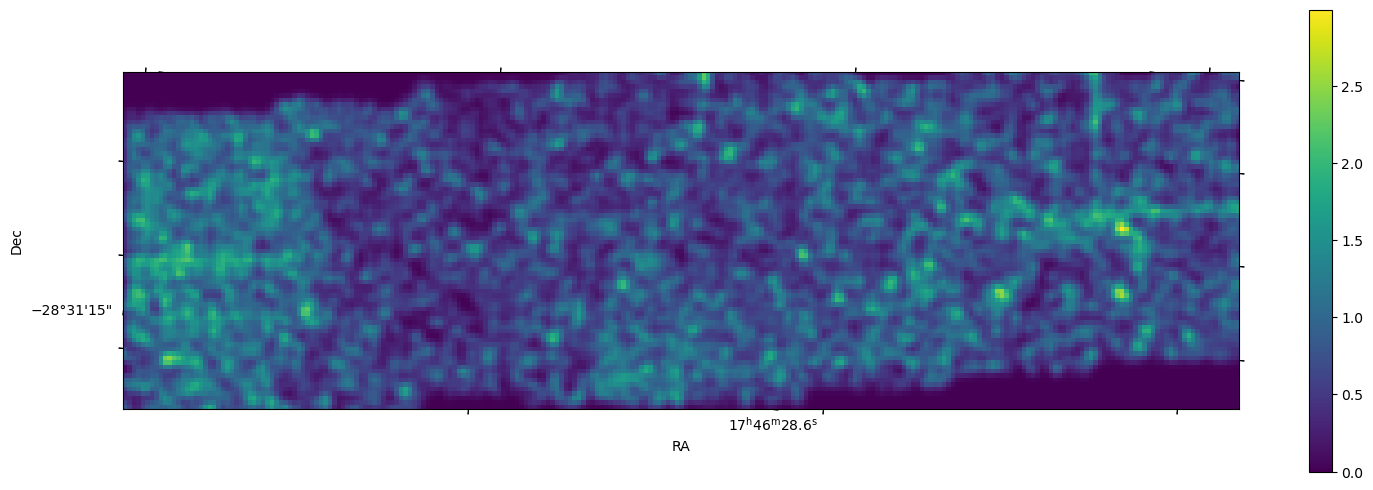

In [43]:
tbl_no_short = cat_use.catalog[~(np.isnan(cat_use.catalog['mag_ab_f405n'])) & ~(np.isnan(cat_use.catalog['mag_ab_f410m'])) & (np.isnan(cat_use.catalog['mag_ab_f182m']))]
_ = star_density_color(tbl_no_short, ww, dx=2, blur=True)

# Filament Stellar Density

In [15]:
cat_use = make_cat_use()

In [16]:
im_filt_fn = f'{basepath}/images/jw02221-o002_t001_nircam_clear-f182m-merged-reproject-nodestreak_i2d-perfilt128.fits'
im_filt = fits.open(im_filt_fn)[0]

In [50]:
ctr_filament = SkyCoord('17:46:20.8194569665', '-28:37:52.4236707380', unit=(u.hourangle, u.deg), frame='icrs')
size_filabox = (2.6762805138*u.arcmin, 86.6778672344*u.arcsec)
reg_filabox = regions.RectangleSkyRegion(center=ctr_filament, width=size_filabox[1], height=size_filabox[0])
cutout_filt = Cutout2D(im_filt.data, position=ctr_filament, size=size_filabox, wcs=WCS(im_filt.header))
cutout_405 = Cutout2D(data_405, position=ctr_filament, size=size_filabox, wcs=ww)

In [18]:

reg_ext_filament = Regions.read(f'{basepath}/regions_/ext_filament.reg')

combined_region = reg_ext_filament[0].to_pixel(cutout_filt.wcs)
for region in reg_ext_filament[1:]:
    combined_region = combined_region | region.to_pixel(cutout_filt.wcs)

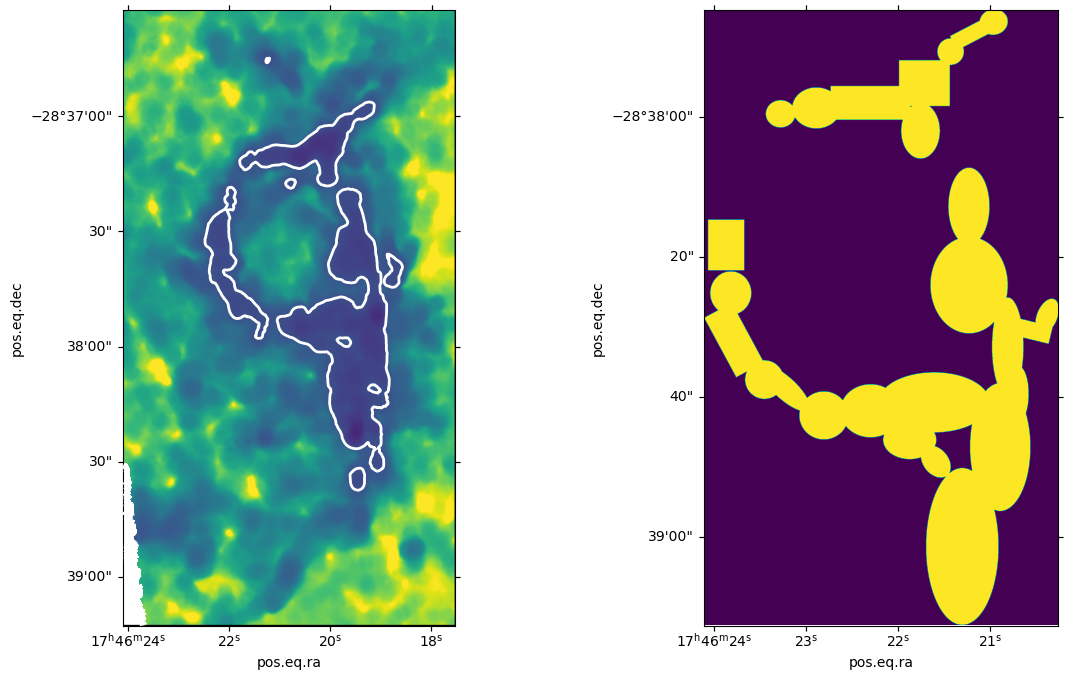

In [19]:
fig = plt.figure(figsize=(14,8))
ax = plt.subplot(121, projection=cutout_filt.wcs)
ax.imshow(cutout_filt.data, vmin=0, vmax=5)
ax.contour(cutout_filt.data, levels=[1.25], colors='white', linewidths=2)
reg_filabox.to_pixel(cutout_filt.wcs).plot(ax=ax)

ax = plt.subplot(122, projection=cutout_filt.wcs)
ax.imshow(combined_region.to_mask())


In [28]:
spatial_mask = cutout_filt.data < 1.25

In [29]:
cat_select = (cat_use.band('F182M') < 20) & (cat_use.band('F182M') > 13) 
cat_spatial = reg_filabox.contains(cat_use.catalog['skycoord_ref'], wcs=cutout_filt.wcs)
cat_in_filament = cat_use.catalog[cat_select & cat_spatial]

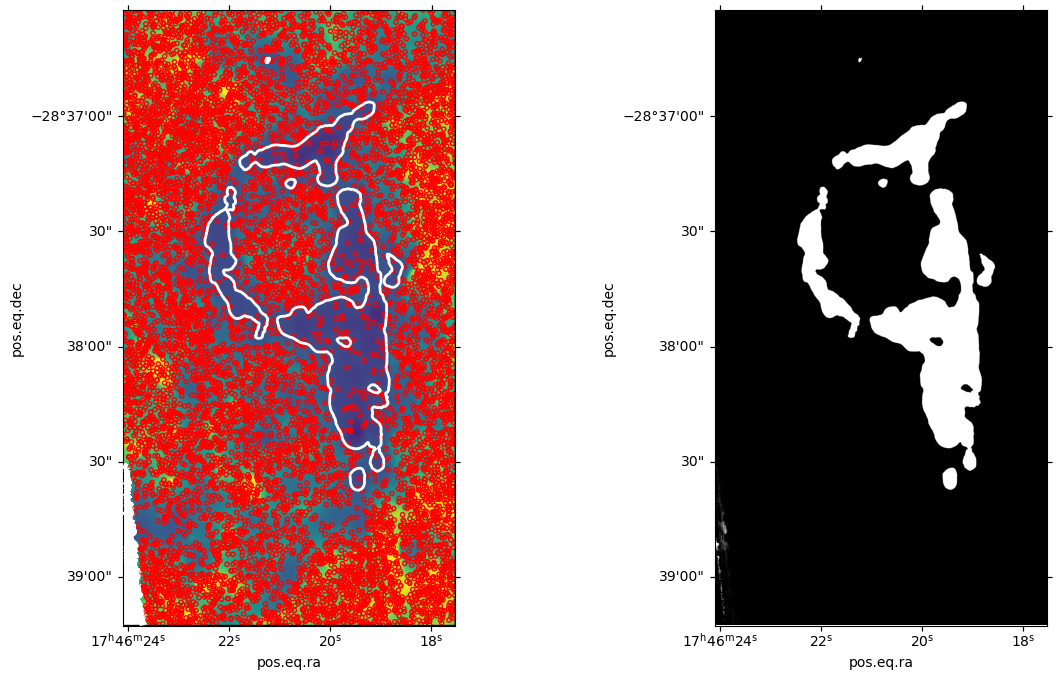

In [12]:
fig = plt.figure(figsize=(14,8))
ax = plt.subplot(121, projection=cutout_filt.wcs)
ax.imshow(cutout_filt.data, vmin=0, vmax=5)
ax.contour(cutout_filt.data, levels=[1.25], colors='white', linewidths=2)
ax.scatter(cat_in_filament['skycoord_ref'].ra, cat_in_filament['skycoord_ref'].dec, edgecolor='r', facecolor='none', transform=ax.get_transform('world'), marker='.')
reg_filabox.to_pixel(cutout_filt.wcs).plot(ax=ax)

ax2 = plt.subplot(122, projection=cutout_filt.wcs)
ax2.imshow(spatial_mask, cmap='gray')

In [30]:
cat_pixel = cutout_filt.wcs.world_to_pixel(cat_in_filament['skycoord_ref'])

In [31]:
cat_pixel_rounded = np.rint(cat_pixel).astype(int)
cat_pixel_rounded.shape

(2, 10616)

In [32]:
cat_pixel_rounded.dtype

dtype('int64')

In [33]:
spatial_mask.shape

(5223, 2819)

In [34]:
contour_mask = spatial_mask[cat_pixel_rounded[1], cat_pixel_rounded[0]]

In [35]:
area_contour = np.sum(spatial_mask) * cutout_filt.wcs.proj_plane_pixel_area().to(u.arcsec**2)
area_contour

<Quantity 1332.31627133 arcsec2>

In [36]:
np.sum(contour_mask)/area_contour

<Quantity 0.15611909 1 / arcsec2>

In [37]:
cat_use_filament = JWSTCatalog(cat_in_filament[contour_mask])
cat_use_whole_filament = JWSTCatalog(cat_in_filament)

(0.0, 6.0)

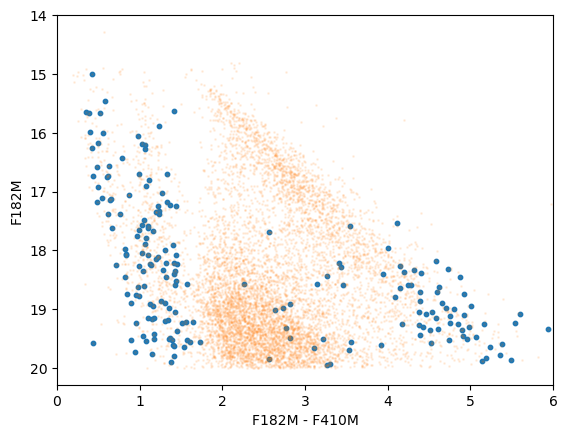

In [21]:
ax = plt.subplot(111)
cat_use_filament.plot_CMD('F182M', 'F410M', 'F182M', ax=ax, s=10)
cat_use_whole_filament.plot_CMD('F182M', 'F410M', 'F182M', ax=ax, s=1, alpha=0.1)
plt.gca().invert_yaxis()
plt.xlim(0, 6)
# filament cloud is causing a few magnitudes of extinction in F182M, 0.2 in color space 
# not seen towards cloud d
# stars seen in cloud d in the same place as that gap are behind the filament cloud
# max distance of stars in front vs minimum distance to stars behind
# how to measure Dmax and Dmin? 

(0.0, 3.0)

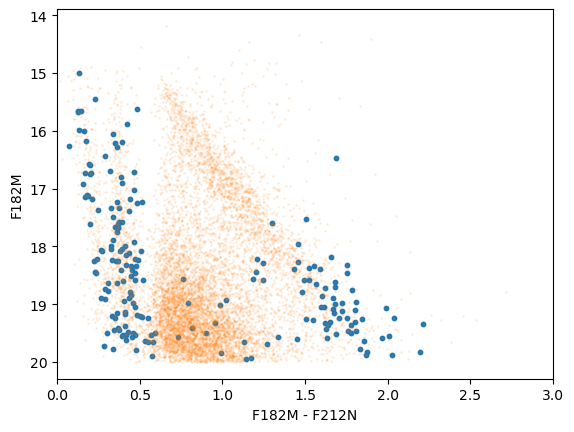

In [33]:
ax = plt.subplot(111)
cat_use_filament.plot_CMD('F182M', 'F212N', 'F182M', ax=ax, s=10)
cat_use_whole_filament.plot_CMD('F182M', 'F212N', 'F182M', ax=ax, s=1, alpha=0.1)
plt.gca().invert_yaxis()
plt.xlim(0, 3)

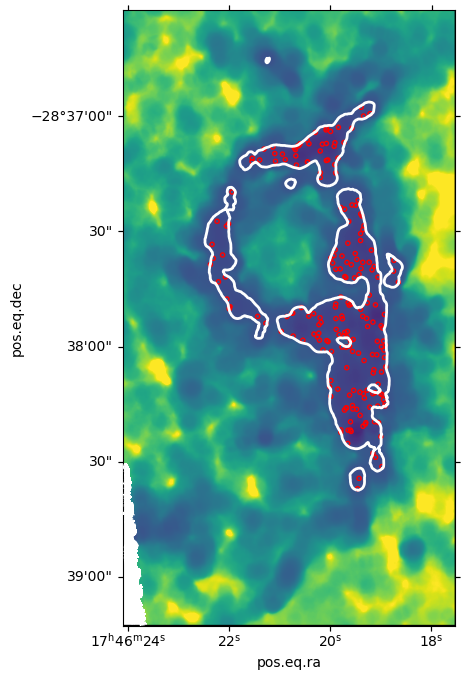

In [34]:
fig = plt.figure(figsize=(14,8))
ax = plt.subplot(111, projection=cutout_filt.wcs)
ax.imshow(cutout_filt.data, vmin=0, vmax=5)
ax.contour(cutout_filt.data, levels=[1.25], colors='white', linewidths=2)
ax.scatter(cat_in_filament['skycoord_ref'].ra[contour_mask], cat_in_filament['skycoord_ref'].dec[contour_mask], edgecolor='r', facecolor='none', transform=ax.get_transform('world'), marker='.')
reg_filabox.to_pixel(cutout_filt.wcs).plot(ax=ax)

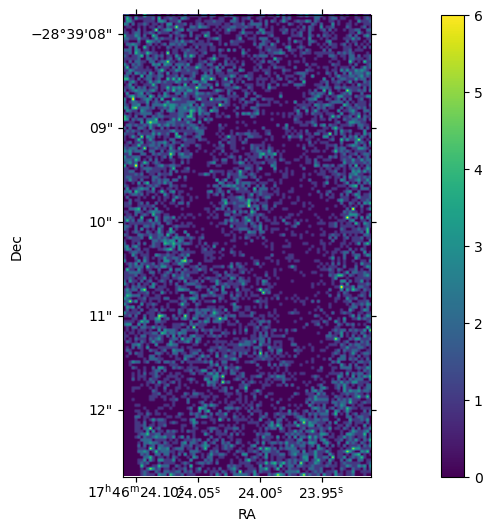

In [86]:
h = star_density_color(cat_in_filament, cutout_filt.wcs, dx=1, blur=False, plot=True, size=size_filabox)
h_wcs = make_wcs(h, 1, cutout_filt.wcs.to_header())

In [38]:
cat_mask_filament = combined_region.to_sky(cutout_filt.wcs).contains(cat_in_filament['skycoord_ref'], wcs=cutout_filt.wcs)
cat_mask_filament &= cat_in_filament['mag_ab_f182m'] - cat_in_filament['mag_ab_f410m'] < 2

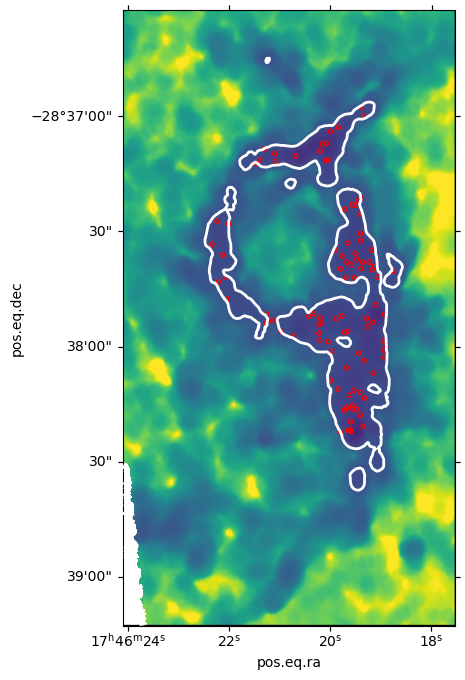

In [26]:
fig = plt.figure(figsize=(14,8))
ax = plt.subplot(111, projection=cutout_filt.wcs)
ax.imshow(cutout_filt.data, vmin=0, vmax=5)
ax.contour(cutout_filt.data, levels=[1.25], colors='white', linewidths=2)
ax.scatter(cat_in_filament['skycoord_ref'].ra[cat_mask_filament], cat_in_filament['skycoord_ref'].dec[cat_mask_filament], edgecolor='r', facecolor='none', transform=ax.get_transform('world'), marker='.')
reg_filabox.to_pixel(cutout_filt.wcs).plot(ax=ax)

In [27]:
star_densities = []

for region in reg_ext_filament:
    masked_cat = cat_in_filament[region.contains(cat_in_filament['skycoord_ref'], wcs=cutout_filt.wcs)]
    reg_area = region.to_pixel(cutout_filt.wcs).area*u.pixel**2 * cutout_filt.wcs.proj_plane_pixel_area().to(u.arcsec**2)/(u.pixel**2)

    star_density = len(masked_cat)/reg_area
    print(f'{star_density:.2f}')# stars/arcsec^2')
    star_densities.append(star_density.value)

0.04 1 / arcsec2
0.07 1 / arcsec2
0.10 1 / arcsec2
0.09 1 / arcsec2
0.11 1 / arcsec2
0.20 1 / arcsec2
0.19 1 / arcsec2
0.26 1 / arcsec2
0.15 1 / arcsec2
0.09 1 / arcsec2
0.17 1 / arcsec2
0.18 1 / arcsec2
0.12 1 / arcsec2
0.14 1 / arcsec2
0.15 1 / arcsec2
0.13 1 / arcsec2
0.21 1 / arcsec2
0.07 1 / arcsec2
0.31 1 / arcsec2
0.34 1 / arcsec2
0.08 1 / arcsec2
0.06 1 / arcsec2
0.08 1 / arcsec2
0.17 1 / arcsec2
0.04 1 / arcsec2
0.29 1 / arcsec2


# Cumulative Number Density vs Extinction

In [39]:
# cat_use
# cat_use_whole_filament
# 
# reg_filabox

In [55]:
area_filabox = np.sum((cutout_405.data != 0) & (np.isnan(cutout_405.data) == False)) * cutout_405.wcs.proj_plane_pixel_area().to(u.arcsec**2)
#reg_filabox.to_pixel(cutout_filt.wcs).area*u.pixel**2 * cutout_filt.wcs.proj_plane_pixel_area().to(u.arcsec**2)/(u.pixel**2)
area_filabox

<Quantity 13684.29604669 arcsec2>

In [56]:
area_fov = image_area#-area_filabox#cutout_filt.data.size * cutout_filt.wcs.proj_plane_pixel_area().to(u.arcsec**2)
area_fov

<Quantity 70265.90364568 arcsec2>

In [57]:
star_densities_filament = []
star_densities_full = []

colors = np.linspace(0, 10, 50)

for c in colors:
    color_filament = (cat_use_whole_filament.color('F182M', 'F410M') < c) & (cat_use_whole_filament.band('f182m') < 20) & (cat_use_whole_filament.band('f182m') > 13)
    color_full = (cat_use.color('F182M', 'F410M') < c) & (cat_use.band('f182m') < 20) & (cat_use.band('f182m') > 13)

    star_density_filament = np.sum(color_filament)/area_filabox
    star_density_full = np.sum(color_full)/area_fov

    star_densities_filament.append(star_density_filament.value)
    star_densities_full.append(star_density_full.value)

(0.0, 4.0)

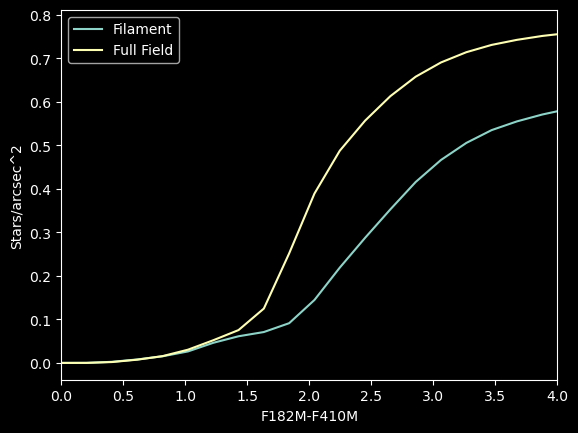

In [58]:
plt.style.use('dark_background')

plt.plot(colors, star_densities_filament, label='Filament')
plt.plot(colors, star_densities_full, label='Full Field')
plt.xlabel('F182M-F410M')
plt.ylabel('Stars/arcsec^2')
plt.legend()
plt.xlim(0, 4)

In [44]:
star_densities_filament = []
star_densities_full = []

color_bins = np.linspace(0, 10, 50)

for c in range(len(color_bins)-1):
    color_filament = (cat_use_whole_filament.color('F182M', 'F410M') > color_bins[c]) & (cat_use_whole_filament.color('F182M', 'F410M') > color_bins[c+1]) & (cat_use_whole_filament.band('f182m') < 20) & (cat_use_whole_filament.band('f182m') > 13)
    color_full = (cat_use.color('F182M', 'F410M') > color_bins[c]) & (cat_use.color('F182M', 'F410M') > color_bins[c+1]) & (cat_use.band('f182m') < 20) & (cat_use.band('f182m') > 13)

    star_density_filament = np.sum(color_filament)/area_filabox
    star_density_full = np.sum(color_full)/area_fov

    star_densities_filament.append(star_density_filament.value)
    star_densities_full.append(star_density_full.value)

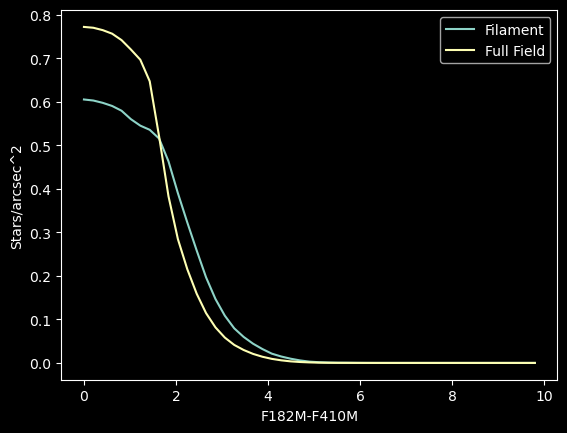

In [46]:
plt.plot(color_bins[:-1], star_densities_filament, label='Filament')
plt.plot(color_bins[:-1], star_densities_full, label='Full Field')
plt.xlabel('F182M-F410M')
plt.ylabel('Stars/arcsec^2')
plt.legend()
#plt.axvline(2, color='white', linestyle='--')
#plt.axvline(1.1, color='white', linestyle='--')

In [ ]:
# using the trilegal data on the same plot
# plot stellar density vs color and see if we can get it to match the "non-filament" case up to a certain point
# how close can we get trilegal to match the non-filament case?
# overplot trilegal on this plot
# use contour plot to measure stellar density across filament at its deepest +- sqrt of number of stars (poisson noise)
# overplot trilegal model with a few different assumed extinction laws

In [ ]:
# overall density map. Draw a contour where density of stars is 0.1, find what the extinction for the "non extincted"
# at what extinction do we see that low density of stars elsewhere in the field? match with non-cumulative number denstiy vs color/extinction 